# Fig5

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from zebrafish_ms2_paper.trace_analysis import extract_traces, remove_blips, predict_protein, predict_protein_v2, compute_trace_uncertainty, enforce_1spot_per_nucleus, binarize_trace
from zebrafish_ms2_paper.ap_analysis import get_ap_for_somites, get_ap_for_spots, filter_spots_by_distance_from_somite, filter_spots_by_perp_distance_from_ap_axis
import pandas as pd
import pickle
import matplotlib as mpl

In [2]:
%matplotlib qt

In [3]:
"""specify the paths to the required datasets"""
#path_to_manual_dataset1 = r'/media/brandon/Data1/Somitogenesis/Dorado/rerun_quantification_July7_2023/filtered_df.pkl'
path_to_manual_dataset1 = r'/media/brandon/Data1/Somitogenesis/Dorado/manual_traces/all_manual_spots_quant_std_offset.pkl'
path_to_non_blank_timepoints = r'/media/brandon/Data1/Somitogenesis/Dorado/non_blank_timepoints_full.pkl'

In [4]:
# plot params
fontweight = 'bold'
fontsize = 24
fontproperties = {'family':'sans-serif','sans-serif':['Arial'],'weight' : fontweight, 'size' : fontsize}
rc('axes', linewidth=4)

In [5]:
# correct time stamps
with open(path_to_non_blank_timepoints,'rb') as fp:
    non_blank_timepoints = pickle.load(fp)

## Fig 5A
Plot example traces. Here we plot 5 traces. We ended up only showing 4 and changing the order to make the figure smaller.

In [4]:
# load the manual dorado dataset
df = pd.read_pickle(path_to_manual_dataset1)

minimum_number_of_spots = 20
good_ids = [2715, 5070, 2831, 7814, 8258]

df = df[[nuc in good_ids for nuc in df.nucleus_id]]
df = enforce_1spot_per_nucleus(df, method='gauss3d_dog')

# extract culled traces
traces = extract_traces(df, method='gauss3d_dog')

    

In [8]:
plt.figure()
counter = 0
max_inten = df.gauss3d_dog.max()
for i, trace in enumerate(traces):
    t_arr, inten_arr, nucleus = trace
    t_arr = non_blank_timepoints[t_arr.astype('int')]
    
    mrna, protein, fp = predict_protein_v2(inten_arr, t_arr, Tmax=180, t_eval=np.arange(0, 180))

    # for trace uncertainty
    sub_df = df[df.nucleus_id == nucleus]
    t_arr_bkg = sub_df.t.values
    bkg_arr = sub_df.offset.values
    t_arr_bkg = t_arr_bkg[~np.isnan(bkg_arr)]
    bkg_arr = bkg_arr[~np.isnan(bkg_arr)]
    s = compute_trace_uncertainty(t_arr_bkg, bkg_arr, inten_arr)
    l = inten_arr - s
    u = inten_arr + s
    
    counter += 1
    plt.subplot(5, 1, counter)
    # plot protein
    t_eval = np.arange(0, len(protein))
    protein_ids = np.array([t in t_arr for t in t_eval])
    plt.plot(t_arr, protein[protein_ids] / np.max(protein[protein_ids]) * np.max(inten_arr) / max_inten, '-', linewidth=6, alpha=0.5, label='predicted protein', color='c')

    plt.plot(t_arr, inten_arr / max_inten, 'g-', linewidth=6, label='MS2')
    plt.plot(t_arr, inten_arr / max_inten, 'o', label='_nolabel_', markersize=12, fillstyle='none', markeredgecolor='k', markeredgewidth=2)
    plt.fill_between(t_arr, l / max_inten, u / max_inten, facecolor='g', alpha=0.25)
    
    plt.xlim([0, 145])

    if counter == 1:
        plt.legend(loc=2, fontsize=16)

    if counter == 5:
        plt.xticks([0, 30, 60, 90, 120])
        plt.xlabel('time (min)', fontsize=fontsize)
    else:
        plt.xticks([0, 30, 60, 90, 120], labels=[])
    
    if counter == 3:
        plt.ylabel('fluorescence intensity (a.u.) \n', fontsize=fontsize)
    
    ax = plt.gca()
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
            

## Fig5B
Plot a zoom in of a burst

In [9]:
# load the manual dorado dataset
df = pd.read_pickle(path_to_manual_dataset1)

# extract the trace just for the nucleus in question
good_ids = [2831]

df = df[[nuc in good_ids for nuc in df.nucleus_id]]
df = enforce_1spot_per_nucleus(df, method='gauss3d_dog')

# extract culled traces
traces = extract_traces(df, method='gauss3d_dog')

In [10]:
plt.figure()
# use same max intensity from the full set of traces
max_inten = 62139.0
for i, trace in enumerate(traces):
    t_arr, inten_arr, nucleus = trace
    t_arr = non_blank_timepoints[t_arr.astype('int')]
    
    mrna, protein, fp = predict_protein_v2(inten_arr, t_arr, Tmax=180, t_eval=np.arange(0, 180))

    # for trace uncertainty
    sub_df = df[df.nucleus_id == nucleus]
    t_arr_bkg = sub_df.t.values
    bkg_arr = sub_df.offset.values
    t_arr_bkg = t_arr_bkg[~np.isnan(bkg_arr)]
    bkg_arr = bkg_arr[~np.isnan(bkg_arr)]
    s = compute_trace_uncertainty(t_arr_bkg, bkg_arr, inten_arr)
    l = inten_arr - s
    u = inten_arr + s
    
    plt.plot(t_arr, inten_arr / max_inten, 'g-', linewidth=6, label='MS2')
    plt.plot(t_arr, inten_arr / max_inten, 'o', label='_nolabel_', markersize=12, fillstyle='none', markeredgecolor='k', markeredgewidth=2)
    plt.fill_between(t_arr, l / max_inten, u / max_inten, facecolor='g', alpha=0.25)
    
    plt.xlim([56, 64])
    plt.xticks([56, 57, 58, 59, 60, 61, 62, 63, 64])
    plt.xlabel('time (min)', fontsize=fontsize)
    plt.ylabel('fluorescence intensity (a.u.)', fontsize=fontsize)
    
    ax = plt.gca()
    fontweight = 'bold'
    fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()

## Fig5D
Plot an example of a binarized trace

In [16]:
# load the manual dorado dataset
df = pd.read_pickle(path_to_manual_dataset1)

good_ids = [2715]

df = df[[nuc in good_ids for nuc in df.nucleus_id]]
df = enforce_1spot_per_nucleus(df, method='gauss3d_dog')

# extract culled traces
traces = extract_traces(df, method='gauss3d_dog')

            

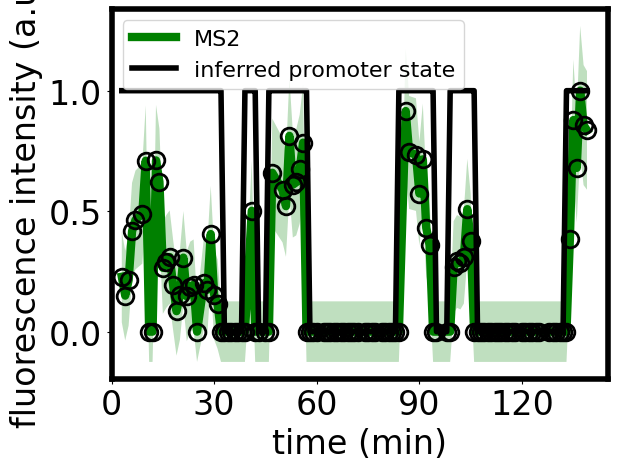

In [7]:
plt.figure()
counter = 0
max_inten = df.gauss3d_dog.max()
for i, trace in enumerate(traces):
    t_arr, inten_arr, nucleus = trace
    t_arr = non_blank_timepoints[t_arr.astype('int')]

    state = binarize_trace(inten_arr, t_arr, thresh=1.0, window_size=3)
    
    # for trace uncertainty
    sub_df = df[df.nucleus_id == nucleus]
    t_arr_bkg = sub_df.t.values
    bkg_arr = sub_df.offset.values
    t_arr_bkg = t_arr_bkg[~np.isnan(bkg_arr)]
    bkg_arr = bkg_arr[~np.isnan(bkg_arr)]
    s = compute_trace_uncertainty(t_arr_bkg, bkg_arr, inten_arr)
    l = inten_arr - s
    u = inten_arr + s
    
    counter += 1
    
    plt.plot(t_arr, inten_arr / max_inten, 'g-', linewidth=6, label='MS2')
    plt.plot(t_arr, inten_arr / max_inten, 'o', label='_nolabel_', markersize=12, fillstyle='none', markeredgecolor='k', markeredgewidth=2)
    plt.fill_between(t_arr, l / max_inten, u / max_inten, facecolor='g', alpha=0.25)
    
    plt.plot(t_arr, state, 'k-', linewidth=4, label='inferred promoter state')
    
    plt.xlim([0, 145])
    plt.legend(loc=2, fontsize=16)

    plt.xticks([0, 30, 60, 90, 120])
    plt.xlabel('time (min)', fontsize=fontsize)
    plt.ylabel('fluorescence intensity (a.u.)', fontsize=fontsize)
    
    ax = plt.gca()
    fontweight = 'bold'
    fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)

# Fig5E
Histogram of number of her1 transcriptional bursts per protein oscilliation

In [13]:
"""bursts per pulse"""
bins = np.array([1, 2, 3])
probs = np.zeros((2,3))
# dorado automatic
probs[0] = np.array([0.8414, 0.1521, 0.0065])
# z1 automatic
probs[1] = np.array([ 0.8824, 0.1176, 0.000])

In [14]:
plt.figure()
for i in range(len(probs)):
    plt.plot(bins, probs[i], 'ko', markersize=18, markerfacecolor = 'g', alpha=0.7)
plt.xlabel('bursts per oscillation', fontsize=24)
plt.ylabel('\n \n probability', fontsize=24)
plt.xticks([1, 2, 3])
plt.xlim([0.5, 3.5])
plt.ylim([-0.05, 1])

ax = plt.gca()
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)

plt.tight_layout()

## TEMP

In [22]:
"""plot style"""
linewidth = 4
mpl.rc('axes', linewidth=linewidth)
mpl.rc('font', family='Arial')
fontsize = 24

def style_axes(ax, fontsize=24):
    plt.minorticks_off()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    plt.tight_layout()
    
    return ax


In [23]:
plt.figure(figsize=(8,4))
counter = 0
max_inten = df.gauss3d_dog.max()
fontsize = 26
for i, trace in enumerate(traces):
    t_arr, inten_arr, nucleus = trace
    t_arr = non_blank_timepoints[t_arr.astype('int')]
    
    # for trace uncertainty
    sub_df = df[df.nucleus_id == nucleus]
    t_arr_bkg = sub_df.t.values
    bkg_arr = sub_df.offset.values
    t_arr_bkg = t_arr_bkg[~np.isnan(bkg_arr)]
    bkg_arr = bkg_arr[~np.isnan(bkg_arr)]
    s = compute_trace_uncertainty(t_arr_bkg, bkg_arr, inten_arr)
    l = inten_arr - s
    u = inten_arr + s
    
    counter += 1
    
    plt.plot(t_arr, inten_arr / max_inten, 'g-', linewidth=6, label='MS2')
    plt.plot(t_arr, inten_arr / max_inten, 'o', label='_nolabel_', markersize=12, fillstyle='none', markeredgecolor='k', markeredgewidth=2)
    plt.fill_between(t_arr, l / max_inten, u / max_inten, facecolor='g', alpha=0.25)
    
    
    plt.xlim([0, 145])

    plt.xticks([0, 30, 60, 90, 120])
    plt.yticks([0, 1])
    plt.xlabel('time (min)', fontsize=fontsize)
    plt.ylabel('her1-MS2 \nfluorescence \nintensity (a.u.)', fontsize=fontsize)
    
    ax = style_axes(plt.gca())

In [24]:
plt.savefig(r'/home/brandon/Documents/jobs_2024/ms2-example.pdf')